# Simulation comparing GLMs and NNs

## Imports

In [1]:
import numpy as np
from sklearn.cross_validation import train_test_split
from scipy import stats
import scipy.sparse as sps

# GLM
from pyglmnet import GLM

# NNs
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

# Plotting
import matplotlib.pyplot as plt
% matplotlib inline

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


## Simulate data

In [2]:
def simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor):

    # Sample design matrix
    X = np.random.randn(n_samples, n_features)
    
    # Rescale
    scale_factor = np.logspace(scale_min, scale_max, n_features)
    for f in range(n_features):
        X[:, f] = scale_factor[f] * X[:, f]
    
    # Sample beta0
    beta0 = effect_size_factor * 3.0 * np.random.rand(1)
    
    # Sample sparse beta
    rvs = stats.norm(loc=0.0, scale=1.0).rvs
    tmp = sps.random(n_features, 1, density=density, data_rvs=rvs)
    beta = effect_size_factor * np.squeeze(tmp.toarray())
    
    # Sample y ~ Poisson(exp(beta0 + X * beta))
    glm_simulator = GLM(distr='softplus')
    y = glm_simulator.simulate(beta0, beta, X)
    
    return beta0, beta, X, y

In [3]:
n_samples = 1000
n_features = 10
scale_min = -2.0
scale_max = 0.0
density = 1.0
effect_size_factor = 0.5

In [4]:
beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor)

In [5]:
beta0, beta

(array([ 0.34565379]),
 array([-0.81028874,  0.13082674,  0.66769508, -0.14882475,  0.12277152,
        -0.07022649,  0.39339838,  0.26294321,  0.45783008,  0.27830391]))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Fit models

### GLMs 

In [7]:
glm = GLM(distr='softplus',
          alpha=0.1,
          tol=1e-8,
          reg_lambda=np.logspace(np.log(0.05), np.log(0.001), 10, base=np.exp(1)),
          learning_rate=0.01,
          solver='batch-gradient',
          max_iter=10000,
          random_state=1,
          score_metric='pseudo_R2')

In [8]:
glm.fit(X_train, y_train)
glm_r2_train = glm[-1].score(X_train, y_train)
glm_r2_test = glm[-1].score(X_test, y_test)
print(glm_r2_train, glm_r2_test)

[ 0.07024158] [ 0.0337059]


In [9]:
y_train_hat = glm[-1].predict(X_train)
y_test_hat = glm[-1].predict(X_test)

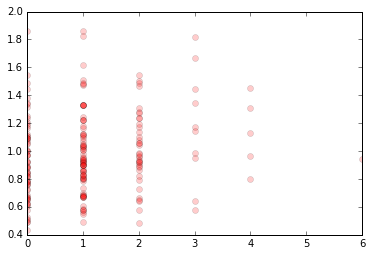

In [10]:
plt.plot(y_test, y_test_hat, 'ro', alpha=0.2)
plt.show()

## Neural Networks

In [11]:
def keras_model(n_features, n_layer1, n_layer2):
    model = Sequential()
    
    model.add(Dense(input_dim=n_features, output_dim=n_layer1, init='glorot_uniform', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    
    model.add(Dense(input_dim=n_features, output_dim=n_layer2, init='glorot_uniform', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(BatchNormalization())
    
    model.add(Dense(output_dim=1, activation='softplus'))
    
    model.compile(loss='poisson', optimizer='rmsprop')
    return model

In [12]:
nn = keras_model(n_features, 1980, 18)

In [345]:
nn.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0.2)

Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 0s - loss: 0.9657 - val_loss: 0.9883
Epoch 2/10
640/640 [==============================] - 0s - loss: 0.9654 - val_loss: 0.9926
Epoch 3/10
640/640 [==============================] - 0s - loss: 0.9651 - val_loss: 0.9865
Epoch 4/10
640/640 [==============================] - 0s - loss: 0.9520 - val_loss: 0.9839
Epoch 5/10
640/640 [==============================] - 0s - loss: 0.9553 - val_loss: 0.9945
Epoch 6/10
640/640 [==============================] - 0s - loss: 0.9527 - val_loss: 0.9821
Epoch 7/10
640/640 [==============================] - 0s - loss: 0.9525 - val_loss: 0.9843
Epoch 8/10
640/640 [==============================] - 0s - loss: 0.9579 - val_loss: 0.9795
Epoch 9/10
640/640 [==============================] - 0s - loss: 0.9529 - val_loss: 0.9791
Epoch 10/10
640/640 [==============================] - 0s - loss: 0.9521 - val_loss: 0.9897


In [346]:
y_train_hat = nn.predict(X_train)
y_test_hat = nn.predict(X_test)

In [13]:
def poisson_pseudoR2(y, yhat, ynull):
    eps = np.spacing(1)
    L1 = np.sum(y * np.log(eps + yhat) - yhat)
    L0 = np.sum(y * np.log(eps + ynull) - ynull)
    LS = np.sum(y * np.log(eps + y) - y)
    R2 = 1 -(LS - L1) / (LS - L0)
    return R2

In [348]:
nn_r2_train = poisson_pseudoR2(y_train, np.squeeze(y_train_hat), np.mean(y_train))
nn_r2_test = poisson_pseudoR2(y_test, np.squeeze(y_test_hat), np.mean(y_train))
print(nn_r2_train, nn_r2_test)

0.0556674209204 0.0208200965427


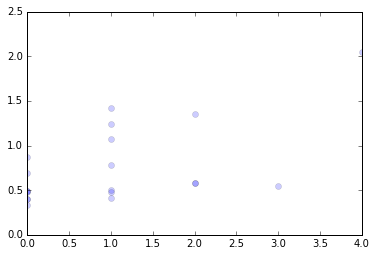

In [334]:
plt.plot(y_test, y_test_hat, 'bo', alpha=0.2)
plt.show()

### Let's iterate over simulations and show repeatable performance

In [16]:
nn_p_sim=list()
glm_p_sim= list()

# Running the above steps with the same parameters in a loop 
print('Running ')
for i in range(10):
    print('%s, '%i)
    n_samples = 1000
    n_features = 10
    scale_min = -2.0
    scale_max = 0.0
    density = 1.0
    effect_size_factor = 0.5
    
    beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor)
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    
    glm = GLM(distr='softplus',
          alpha=0.1,
          tol=1e-8,
          reg_lambda=np.logspace(np.log(0.05), np.log(0.001), 10, base=np.exp(1)),
          learning_rate=0.01,
          solver='batch-gradient',
          max_iter=10000,
          random_state=1,
          score_metric='pseudo_R2')
    
    glm.fit(X_train, y_train)
    glm_r2_test = glm[-1].score(X_test, y_test)
    
    nn = keras_model(n_features, 1980, 18)
    nn.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0, verbose=0)
    y_test_hat = nn.predict(X_test)
    nn_r2_test = poisson_pseudoR2(y_test, np.squeeze(y_test_hat), np.mean(y_train))

    nn_p_sim.append(nn_r2_test)
    glm_p_sim.append(glm_r2_test)


Running 0

Running 1

Running 2

Running 3

Running 4

Running 5

Running 6

Running 7

Running 8

Running 9



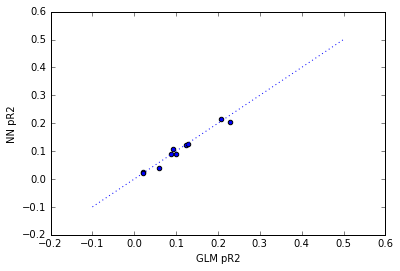

In [18]:
plt.scatter(glm_p_sim,nn_p_sim)
plt.plot([-.1,.5],[-.1,.5],':')
plt.xlabel('GLM pR2')
plt.ylabel('NN pR2')
plt.show()

This looks good! However, I don't see such behavior for smaller effect sizes and a density of 1.

In [34]:
nn_r2_sim=list()
glm_r2_sim= list()
r_r2_sim = list()

# Different parameters this time
print('Running: ')

effect_size_factors = [0.1,0.2,0.3,0.4]
for e in effect_size_factors:
    for i in range(20):
        n_samples = 1000
        n_features = 10
        scale_min = 0.0
        scale_max = 0.0
        density = 1.0
        effect_size_factor = e

        beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor)

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

        # Run glm
        glm = GLM(distr='softplus',
              alpha=0.1,
              tol=1e-8,
              reg_lambda=np.logspace(np.log(0.05), np.log(0.001), 10, base=np.exp(1)),
              learning_rate=0.01,
              solver='batch-gradient',
              max_iter=10000,
              random_state=1,
              score_metric='pseudo_R2')

        glm.fit(X_train, y_train)
        glm_r2_test = glm[-1].score(X_test, y_test)



        # Do NN
        nn = keras_model(n_features, 1980, 18)
        nn.fit(X_train, y_train, nb_epoch=10, batch_size=32, validation_split=0, verbose=0)
        y_test_hat = nn.predict(X_test)
        nn_r2_test = poisson_pseudoR2(y_test, np.squeeze(y_test_hat), np.mean(y_train))

        print('%s: GLM %s; NN %s'% (i,glm_r2_test[0],nn_r2_test))


        nn_r2_sim.append(nn_r2_test)
        glm_r2_sim.append(glm_r2_test)

Running: 
0: GLM 0.00458994995308; NN -0.0234637394151
1: GLM 0.00091049858884; NN -0.0203227227926
2: GLM 0.0384669058029; NN 0.0369121864955
3: GLM 0.0186502583219; NN -0.0334366110165
4: GLM 0.00962868215605; NN -0.0145198865244
5: GLM 0.0392357843204; NN -0.0356215648995
6: GLM -0.000902956274605; NN -0.027515898302
7: GLM 0.03492483021; NN -0.00858163609766
8: GLM 0.0256857293093; NN 0.012999284107
9: GLM 0.00408601338107; NN -0.0501080361345
10: GLM 0.0239474994554; NN -0.0136716466061
11: GLM 0.00596766511854; NN -0.102811209424
12: GLM 0.0143943017015; NN -0.0218114814071
13: GLM 0.0416900660447; NN 0.0297781095941
14: GLM 0.0171807776344; NN -0.0228257711876
15: GLM 0.0252536977036; NN -0.0150866791714
16: GLM 0.0224987568164; NN 0.0155275535511
17: GLM 0.00331657571991; NN -0.0767715378663
18: GLM 0.0248308189771; NN 0.0262109840915
19: GLM 0.0324894372436; NN 0.0272700979119
0: GLM 0.11797466377; NN 0.058010524645
1: GLM 0.083335953051; NN 0.0366739655327
2: GLM 0.0625830800

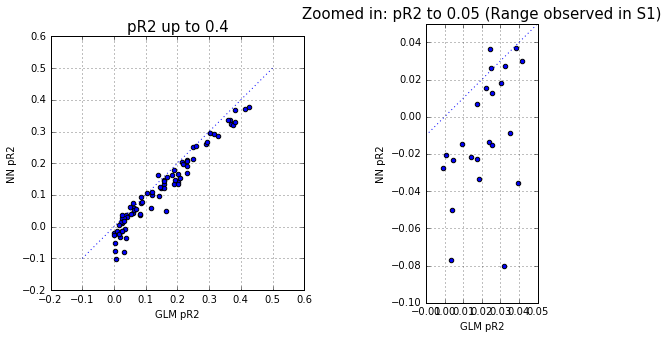

In [48]:
plt.figure(figsize = (10,5),)
plt.subplot(121)
plt.scatter(glm_r2_sim,nn_r2_sim)
plt.plot([-.1,.5],[-.1,.5],':')
plt.xlabel('GLM pR2')
plt.ylabel('NN pR2')
plt.grid()
plt.gca().set_aspect('equal')
plt.title('pR2 up to 0.4',fontsize=15)

plt.subplot(122)
plt.scatter(glm_r2_sim,nn_r2_sim)
plt.plot([-.01,.05],[-.01,.05],':')
plt.axis([-0.01,0.05,-0.1,.05])
plt.xlabel('GLM pR2')
plt.ylabel('NN pR2')
plt.grid()
plt.title('Zoomed in: pR2 to 0.05 (Range observed in S1)',fontsize=15)
plt.gca().set_aspect('equal')

plt.show()

### Simulate with current convenience functions

In [44]:
from sklearn.cross_validation import KFold

def glm_pyglmnet(Xr, Yr, Xt):
    glm = GLM(distr='softplus',
          alpha=0.1,
          tol=1e-8,
          reg_lambda=np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1)),
          learning_rate=0.01,
          solver='batch-gradient',
          max_iter=10000,
          random_state=1,
          score_metric='pseudo_R2')
    
    glm.fit(Xr, Yr)
    Yt = glm[-1].predict(Xt)
    
    return Yt

def fit_cv(X, Y, algorithm = 'glm_pyglmnet', n_cv=10, verbose=1, label=[],func=None):

    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    if len(label)>0:
        skf  = LabelKFold(np.squeeze(label), n_folds=n_cv)
    else:
        skf  = KFold(n=np.size(Y), n_folds=n_cv, shuffle=True, random_state=42)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv)
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        if func:
            Yt_hat = func(Xr, Yr, Xt)
        else:
            Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

    if verbose > 2:
        print("Mean y: "+str(np.mean(Y))+", mean yhat: "+str(np.mean(Y_hat)))
    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                     np.std(pR2_cv)/np.sqrt(n_cv)))

    
    return Y_hat, pR2_cv

In [34]:
## the neural net from above
def nn_eval(Xr, Yr, Xt):
    if np.ndim(Xr)==1:
        Xr = np.transpose(np.atleast_2d(Xr))

    hist = nn.fit(X_train, y_train, nb_epoch=10, batch_size=32,verbose=0)
    result = nn.predict_proba(Xt)
    return result[:,0]


In [35]:

YThat, PR2 = fit_cv(X, y, algorithm = 'nn_eval', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
 32/200 [===>..........................] - ETA: 0spR2:  0.93652332524
...runnning cv-fold 2 of 5


//anaconda/lib/python3.5/site-packages/Keras-1.1.0-py3.5.egg/keras/models.py:760: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


 32/200 [===>..........................] - ETA: 0spR2:  0.980601330616
...runnning cv-fold 3 of 5
 32/200 [===>..........................] - ETA: 0spR2:  0.979704993713
...runnning cv-fold 4 of 5
 32/200 [===>..........................] - ETA: 0spR2:  0.982490283785
...runnning cv-fold 5 of 5
 32/200 [===>..........................] - ETA: 0spR2:  0.985956707142
pR2_cv: 0.973055 (+/- 0.008225)


Same result. Perhaps the error is with the current neural net parameters?

In [39]:
from keras.optimizers import Nadam
from keras.layers.advanced_activations import ParametricSoftplus
from keras.regularizers import l1l2

def build_nn(params):
    
    params['n1']=int(params['n1'])
    params['n2']=int(params['n2'])
    params['nb']=int(params['nb'])
    params['dropout']=float(params['dropout'])
    params['l1'],params['l2'] = float(params['l1']),float(params['l2'])
    
    def nn_new(Xr, Yr, Xt):
        if np.ndim(Xr)==1:
            Xr = np.transpose(np.atleast_2d(Xr))

        model = Sequential()
        model.add(Dense(params['n1'], input_dim=np.shape(Xr)[1], init='glorot_normal',
                    activation='relu', W_regularizer=l1l2(params['l1'],params['l2'])))
        model.add(Dropout(params['dropout']))
        model.add(Dense(params['n2'], init='glorot_normal'
                        , activation='relu',W_regularizer=l1l2(params['l1'],params['l2'])))
        model.add(Dense(1,activation='softplus'))
        
        optim = Nadam()
        model.compile(loss='poisson', optimizer=optim)
        hist = model.fit(Xr, Yr, batch_size = 32, nb_epoch=params['nb'], verbose=0, validation_split=0.0)
        result = model.predict(Xt)
        return result[:,0]

    return nn_new

In [40]:
params = {'dropout': 0.5,
  'l1': 0.0,
  'l2': 0.0,
  'n1': 1980,
  'n2': 18,
  'nb': 5}
nn_orig = build_nn(params)


In [41]:
YThat, PR2 = fit_cv(X, y, algorithm = 'nn_orig', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.940262844001
...runnning cv-fold 2 of 5
pR2:  0.958189413643
...runnning cv-fold 3 of 5
pR2:  0.961056311346
...runnning cv-fold 4 of 5
pR2:  0.966486921618
...runnning cv-fold 5 of 5
pR2:  0.959694369751
pR2_cv: 0.957138 (+/- 0.003976)


It looks like there's no bug here: comparable results with the current neural net. Perhaps the discrepancy arises with data scaling?

### Simulate as before

First with 1000 x 10 data, like above.

In [50]:
# An example S1 fit
# B = array([-0.04393966,  0.01458511, -0.01989851, -0.0094703 ])
# B0=-1.15351603

X = np.random.randn(1000, 10)

B = np.array([0.1,0.1,0.01,0.01, 0.01,0.01,0.01,0.01,0.01,0.01])
B0 = -2
yhat = glm.simulate(B0,B,X)


YThat, PR2 = fit_cv(X, y, algorithm = 'nn_orig', n_cv=5, verbose=2, label=[])
YThat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.00408552991316
...runnning cv-fold 2 of 5
pR2:  -0.0290121602071
...runnning cv-fold 3 of 5
pR2:  0.0158560442089
...runnning cv-fold 4 of 5
pR2:  -0.0392530735383
...runnning cv-fold 5 of 5
pR2:  -0.0608780128805
pR2_cv: -0.021840 (+/- 0.012604)
...runnning cv-fold 1 of 5
pR2:  0.00411789772037
...runnning cv-fold 2 of 5
pR2:  0.00288054137381
...runnning cv-fold 3 of 5
pR2:  0.00237670118599
...runnning cv-fold 4 of 5
pR2:  0.00108928264176
...runnning cv-fold 5 of 5
pR2:  0.000814098538951
pR2_cv: 0.002256 (+/- 0.000541)


Now with the dimensions of the S1 data

In [51]:
# An example S1 fit
# B = array([-0.04393966,  0.01458511, -0.01989851, -0.0094703 ])
# B0=-1.15351603

X = np.random.randn(37587, 4)

B = np.array([0.1,0.1,0.01,0.01]) #should lead to 0.117381 (R) or 0.099076 (pyglmnet with above params)
B0=-2
yhat = glm.simulate(B0,B,X)


YThat, PR2 = fit_cv(X, y, algorithm = 'nn_orig', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.0146421713448
...runnning cv-fold 2 of 5
pR2:  -0.0122915243984
...runnning cv-fold 3 of 5
pR2:  -0.0027749365029
...runnning cv-fold 4 of 5
pR2:  -0.073865667698
...runnning cv-fold 5 of 5
pR2:  -0.0044991617879
pR2_cv: -0.015758 (+/- 0.013576)


In [47]:
YThat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.000363083917906
...runnning cv-fold 2 of 5
pR2:  -0.000345731734936
...runnning cv-fold 3 of 5
pR2:  6.45289559824e-05
...runnning cv-fold 4 of 5
pR2:  0.000205615146977
...runnning cv-fold 5 of 5
pR2:  -0.000234163578046
pR2_cv: 0.000011 (+/- 0.000119)


Both of these seem to indicate the discrepancy lies with the scaling of the data.

Let's see what happens when we don't scale the data at all:

In [99]:
n_samples = 1000
n_features = 10
scale_min = 0 # note: on log scale. 0 --> scale of 1
scale_max = 0
density = 0.5
effect_size_factor = 1

beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor)

In [100]:
YThat, PR2 = fit_cv(X, y, algorithm = 'nn_orig', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.222445915466
...runnning cv-fold 2 of 5
pR2:  0.198419054237
...runnning cv-fold 3 of 5
pR2:  0.138351313684
...runnning cv-fold 4 of 5
pR2:  0.124691032788
...runnning cv-fold 5 of 5
pR2:  0.24846376861
pR2_cv: 0.186474 (+/- 0.021366)


In [101]:
YThat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.199750185786
...runnning cv-fold 2 of 5
pR2:  0.173520385166
...runnning cv-fold 3 of 5
pR2:  0.140591900879
...runnning cv-fold 4 of 5
pR2:  0.15871643725
...runnning cv-fold 5 of 5
pR2:  0.184577989685
pR2_cv: 0.171431 (+/- 0.009147)


Or how about decreasing the effect size:

In [104]:
effect_size_factor = 0.1
beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, effect_size_factor)

In [105]:
YThat, PR2 = fit_cv(X, y, algorithm = 'nn_orig', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  -0.0117207579121
...runnning cv-fold 2 of 5
pR2:  0.0161017223372
...runnning cv-fold 3 of 5
pR2:  -0.0780054035744
...runnning cv-fold 4 of 5
pR2:  -0.00711248082106
...runnning cv-fold 5 of 5
pR2:  -0.126864449178
pR2_cv: -0.041520 (+/- 0.023670)


In [106]:
YThat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=5, verbose=2, label=[])

...runnning cv-fold 1 of 5
pR2:  0.000149669321342
...runnning cv-fold 2 of 5
pR2:  4.2505820484e-05
...runnning cv-fold 3 of 5
pR2:  -1.13653606917e-05
...runnning cv-fold 4 of 5
pR2:  -9.89793645845e-06
...runnning cv-fold 5 of 5
pR2:  -0.000108128576591
pR2_cv: 0.000013 (+/- 0.000038)


This seems to be it. Let's plot the difference in pR2 vs effect size:

In [113]:
effects  = np.arange(0,0.5,0.02)
nn_p=list()
glm_p= list()
for e in effects:
    beta0, beta, X, y = simulate_data(n_samples, n_features, scale_min, scale_max, density, e)
    YThat, PR2_nn = fit_cv(X, y, algorithm = 'nn_orig', n_cv=5, verbose=0, label=[])
    YThat, PR2 = fit_cv(X, y, algorithm = 'glm_pyglmnet', n_cv=5, verbose=0, label=[])
    print(e)
    nn_p.append(PR2_nn)
    glm_p.append(PR2)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48


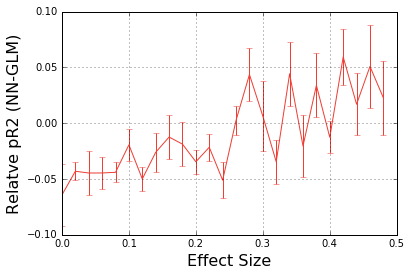

In [121]:
sn = np.sqrt(5)
yy = np.mean(np.array(nn_p), axis=1)-np.mean(np.array(glm_p), axis=1)
# error propogated from CV variance of both methods
yerr = np.sqrt(np.std(np.array(nn_p), axis=1)**2+np.std(np.array(glm_p), axis=1)**2)/sn

p1,c,b=plt.errorbar(effects, yy, yerr = yerr , alpha=1,color='#EF3E34')
plt.grid()
plt.xlabel('Effect Size',fontsize=16)
plt.ylabel('Relatve pR2 (NN-GLM)',fontsize=16)
plt.show()